### Environment setup

In [1]:
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from dataLoader import get_dataset
from model import get_model

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

/home/chao/anaconda3/envs/fl/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.9.0-dev20220224). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


1 Physical GPUs, 1 Logical GPUs


### Loading data
- download the data **monet_tfrec** and **photo_tfrec** in the dataset folder.
- [config kaggle API](https://github.com/Kaggle/kaggle-api)

(-0.5, 255.5, 255.5, -0.5)

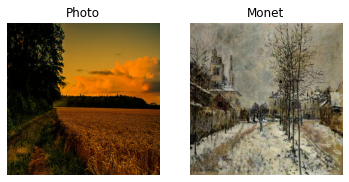

In [4]:
BATCH_SIZE = 32
# monet_ds, photo_ds = get_dataset(BATCH_SIZE)
monet_ds, photo_ds = get_dataset(BATCH_SIZE, repeat=True)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)
plt.axis('off')

### Training

In [5]:
from model import CustomCallback

ganModel = get_model()

monet_num = 300
photo_num = 7038

ganModel.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=2,
    # steps_per_epoch=(max(monet_num, photo_num)//16)
    steps_per_epoch=1000,
    callbacks=[CustomCallback()]
)

# store the model for later use
if os.path.exists('./saved_generator') == True:
    shutil.rmtree('./saved_generator')
os.mkdir('./saved_generator')

ganModel.m_gen.save('./saved_generator')

Epoch 1/2
1000/1000 [==============================] - 815s 800ms/step - monet_gen_loss: 2.9849 - photo_gen_loss: 3.0799 - monet_disc_loss: 0.6451 - photo_disc_loss: 0.6270
Epoch 2/2
1000/1000 [==============================] - 801s 801ms/step - monet_gen_loss: 2.3448 - photo_gen_loss: 2.4439 - monet_disc_loss: 0.6524 - photo_disc_loss: 0.6310


INFO:tensorflow:Assets written to: ./saved_generator/assets


INFO:tensorflow:Assets written to: ./saved_generator/assets


### Show some reuslts

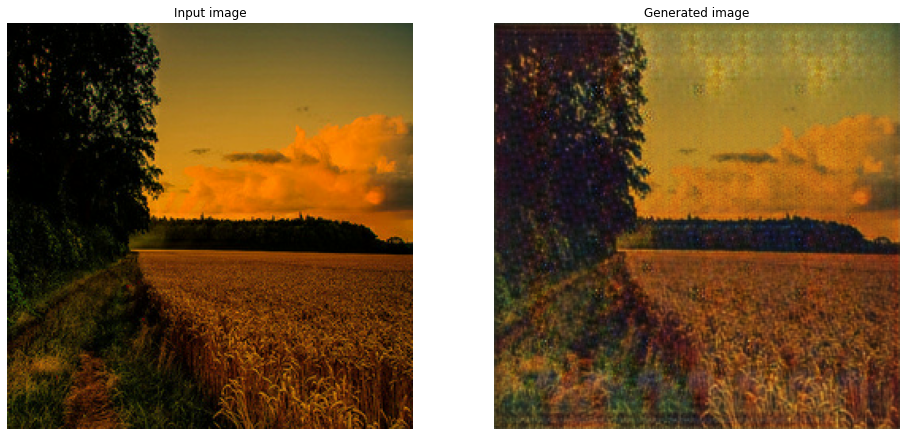

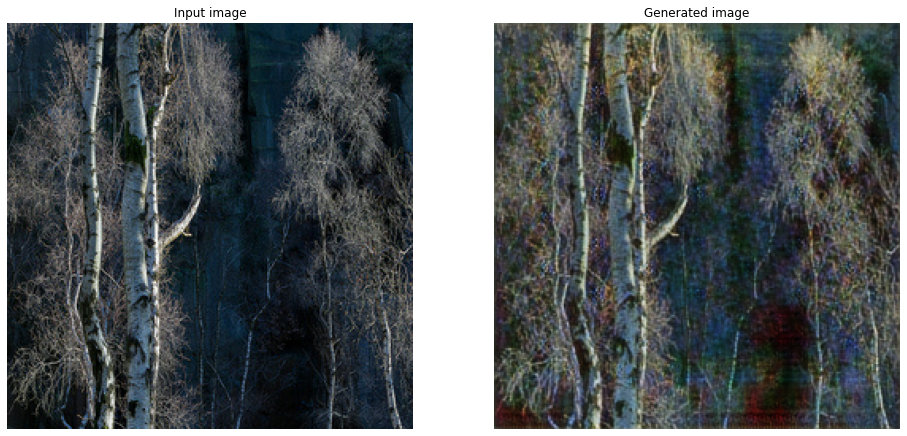

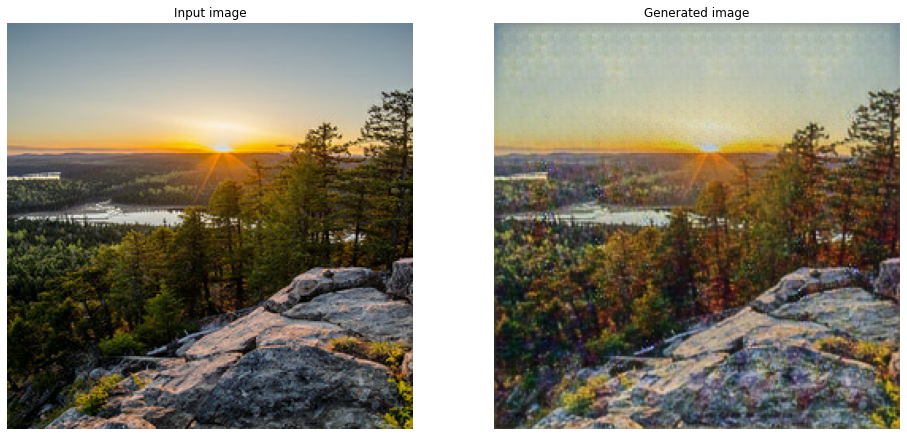

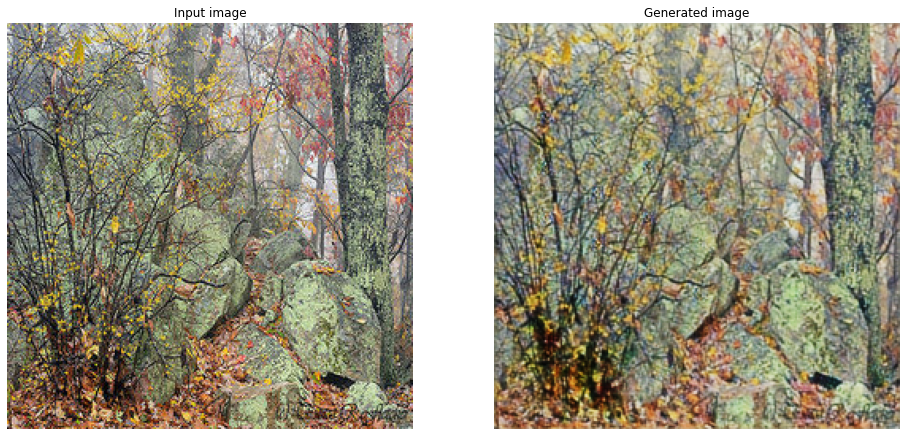

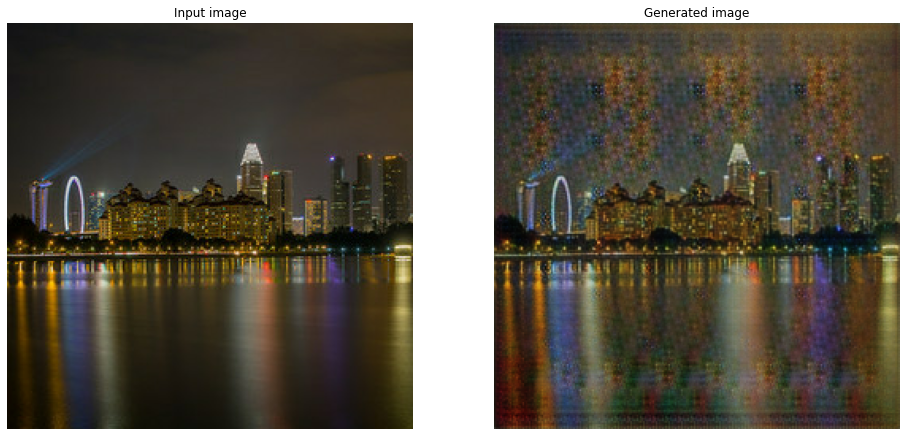

In [6]:
monet_generator = tf.keras.models.load_model(
    './saved_generator', compile=False)

ds_iter = iter(photo_ds)
for n_sample in range(5):
    example_sample = next(ds_iter)
    generated_sample = monet_generator(example_sample)

    f = plt.figure(figsize=(16, 16))

    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.axis('off')

    plt.subplot(122)
    plt.title('Generated image')
    plt.imshow(generated_sample[0] * 0.5 + 0.5)
    plt.axis('off')
    plt.show()


### Save as zip

In [16]:
import PIL
import shutil
if os.path.exists('./ret_imgs') == False:
    os.mkdir('./ret_imgs')

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("./ret_imgs/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("./ret_imgs", 'zip', "./ret_imgs")

'/home/chao/EE5003/I-am-a-painter/ret_imgs.zip'

### Saliency map

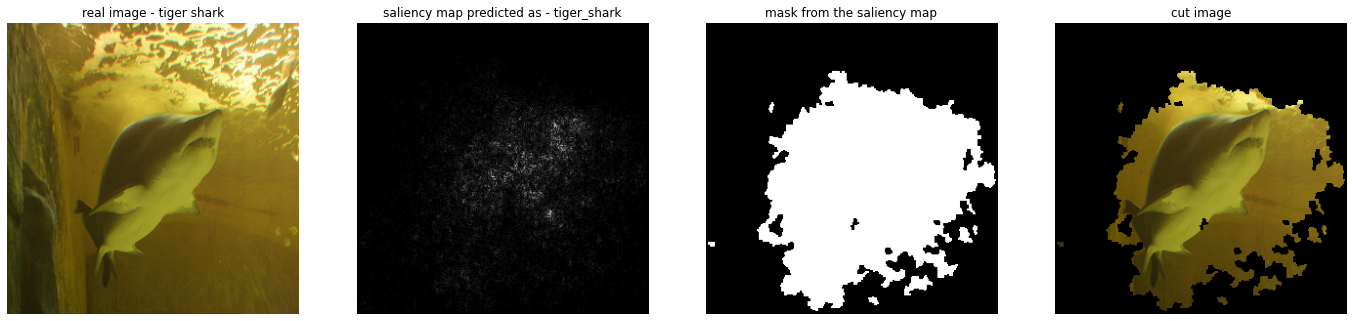

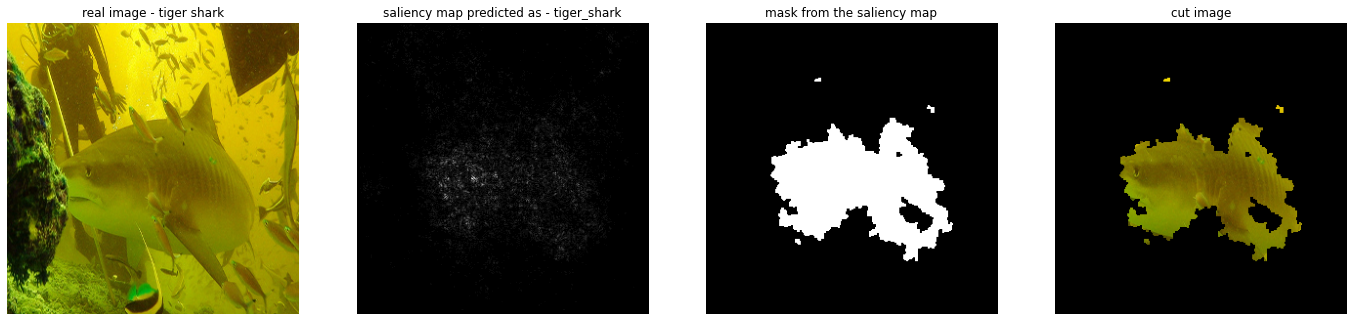

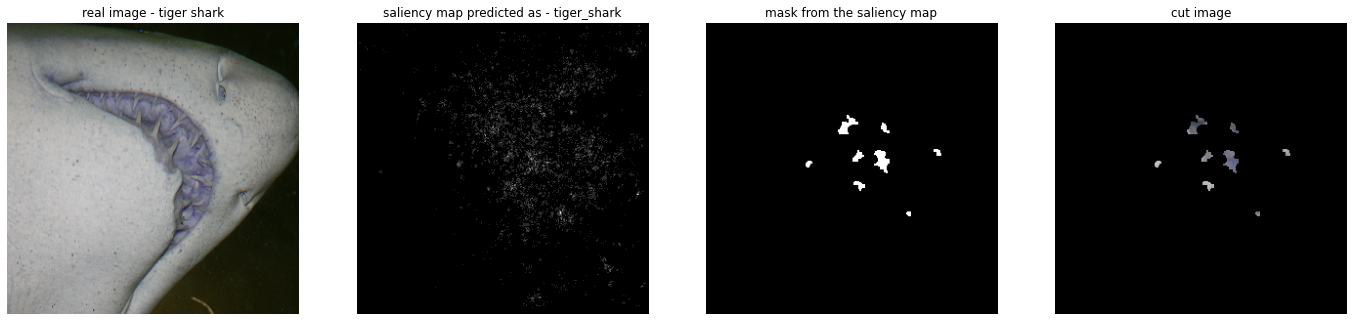

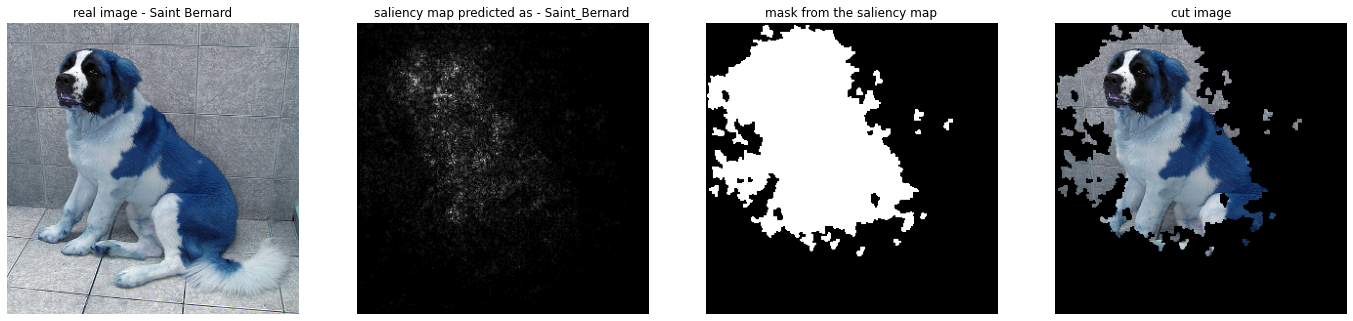

In [10]:
import matplotlib.pyplot as plt
from saliency import get_saliency_map, saliency_graph_cut
from dataLoader import get_saliency_data, imagenet_idx_to_label
import numpy as np

imgs, labels = get_saliency_data(img_shape=(299, 299))
saliency_map, pred_rets = get_saliency_map(imgs, labels)
cut_imgs, masks = saliency_graph_cut(imgs, saliency_map, 10, 0)
# print(saliency_map[0])
# print(pred_rets)
idx_map = imagenet_idx_to_label()

plt_start = 4
img_num = 4

for idx in range(plt_start, plt_start + img_num):
    img = imgs[idx]
    saliency_img = saliency_map[idx]
    mask = masks[idx]
    cut_img = cut_imgs[idx]

    label = idx_map[labels[idx]]
    pred_label = pred_rets[idx][0][1]

    f = plt.figure(figsize=(24, 24))

    plt.subplot(141)
    plt.title(f"real image - {label}")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(142)
    plt.title(f"saliency map predicted as - {pred_label}")
    plt.imshow(saliency_img, cmap='gray')
    plt.axis('off')

    plt.subplot(143)
    plt.title(f"mask from the saliency map")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.subplot(144)
    plt.title(f"cut image")
    plt.imshow(cut_img)
    plt.axis('off')

    plt.show()
